# Pete's EDA: Housing Affordability and Commute Tradeoffs

**Research Questions:**
- RQ1: How does commute time influence housing affordability across metro areas?
- RQ2: Are there demographic disparities in affordability/commute tradeoffs?
- RQ3: Which ZCTAs face the highest combined pressure (high rent burden and long commutes), and how does that relate to transit access?

**Current Data (September 2025 Snapshot):**
- 653 ZCTAs across 4 metros: Phoenix (151), Memphis (40), Los Angeles (271), Dallas-Fort Worth (191)
- Variables available:
  - ZCTA5CE: ZIP code tabulation area identifier
  - rent_to_income: rent burden ratio
  - long45_share: share of workers with 45+ min commutes
  - long60_share: share of workers with 60+ min commutes
  - commute_min_proxy: estimated average commute time
  - ttw_total: total workers (travel time to work)
  - period: data snapshot date
  - zori: Zillow observed rent index
  - stops_per_km2: transit stop density

**Data to Add:**
- Demographics (Census B03002, B02001): race/ethnicity breakdowns
- Income data (Census B19013): median household income by ZCTA

## Setup: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Libraries loaded successfully')

Libraries loaded successfully


In [2]:
# Load all metro datasets
phoenix = pd.read_csv('../data/raw/final_zcta_dataset_phoenix.csv')
memphis = pd.read_csv('../data/raw/final_zcta_dataset_memphis.csv')
los_angeles = pd.read_csv('../data/raw/final_zcta_dataset_los_angeles.csv')
dallas = pd.read_csv('../data/raw/final_zcta_dataset_dallas.csv')

# Add metro identifier
phoenix['metro'] = 'Phoenix'
memphis['metro'] = 'Memphis'
los_angeles['metro'] = 'Los Angeles'
dallas['metro'] = 'Dallas-Fort Worth'

# Combine all metros
df = pd.concat([phoenix, memphis, los_angeles, dallas], ignore_index=True)

print(f'Total records: {len(df)}')
print(f'Phoenix: {len(phoenix)}, Memphis: {len(memphis)}, LA: {len(los_angeles)}, Dallas: {len(dallas)}')

Total records: 649
Phoenix: 150, Memphis: 39, LA: 270, Dallas: 190


## Data Overview

In [3]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ZCTA5CE            649 non-null    int64  
 1   rent_to_income     637 non-null    float64
 2   long45_share       645 non-null    float64
 3   long60_share       645 non-null    float64
 4   commute_min_proxy  645 non-null    float64
 5   ttw_total          649 non-null    float64
 6   period             573 non-null    object 
 7   zori               573 non-null    float64
 8   stops_per_km2      649 non-null    float64
 9   metro              649 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 50.8+ KB


In [4]:
# First few rows
df.head()

,ZCTA5CE,rent_to_income,long45_share,long60_share,commute_min_proxy,ttw_total,period,zori,stops_per_km2,metro
0,85003,0.291375,0.068853,0.059311,5.513359,2788.0,2025-09-30,1781.142157,17.295065,Phoenix
1,85004,0.382202,0.096454,0.065302,6.517524,5738.0,2025-09-30,1824.106878,18.415723,Phoenix
2,85006,0.243999,0.050274,0.033701,3.614925,9884.0,2025-09-30,1438.695628,12.964971,Phoenix
3,85007,0.255801,0.106325,0.078456,7.746845,5308.0,2025-09-30,1450.002646,11.023520,Phoenix
4,85008,0.264548,0.076328,0.052986,5.717924,29411.0,2025-09-30,1457.858483,6.127955,Phoenix


In [5]:
# Summary statistics
df.describe()

,ZCTA5CE,rent_to_income,long45_share,long60_share,commute_min_proxy,ttw_total,zori,stops_per_km2
count,649.000000,637.000000,645.000000,645.000000,645.000000,649.000000,573.000000,649.000000
mean,81865.329738,0.259754,0.166620,0.119197,11.998339,13333.212635,2335.388719,3.519767
std,12762.844692,0.057873,0.063324,0.050611,4.661733,8172.907397,1097.502259,5.793923
min,38002.000000,0.085953,0.022608,0.012439,1.538381,0.000000,917.729377,0.000000
25%,76018.000000,0.225513,0.122644,0.081910,8.731680,7229.000000,1671.714902,0.020870
50%,85268.000000,0.255801,0.166713,0.117527,12.024840,12618.000000,2137.083333,1.167294
75%,90403.000000,0.289921,0.203986,0.149506,14.922152,17946.000000,2755.455863,4.907871
max,91803.000000,0.580212,0.394507,0.305380,28.313399,44521.000000,12446.388889,53.879431


In [6]:
# Check for missing values
missing = df.isnull().sum()
missing[missing > 0]

rent_to_income       12
long45_share          4
long60_share          4
commute_min_proxy     4
period               76
zori                 76
dtype: int64

## RQ1: Commute Time and Housing Affordability

Exploring the relationship between commute times and rent-to-income ratios across metros.

In [7]:
# Correlation analysis
correlation_vars = ['rent_to_income', 'commute_min_proxy', 'long45_share', 'long60_share', 'zori', 'stops_per_km2']
df[correlation_vars].corr()

,rent_to_income,commute_min_proxy,long45_share,long60_share,zori,stops_per_km2
rent_to_income,1.000000,-0.062625,-0.083743,-0.066307,-0.073088,0.439967
commute_min_proxy,-0.062625,1.000000,0.991939,0.976169,0.229554,-0.041960
long45_share,-0.083743,0.991939,1.000000,0.951770,0.227574,-0.049084
long60_share,-0.066307,0.976169,0.951770,1.000000,0.201529,-0.053829
zori,-0.073088,0.229554,0.227574,0.201529,1.000000,0.096278
stops_per_km2,0.439967,-0.041960,-0.049084,-0.053829,0.096278,1.000000


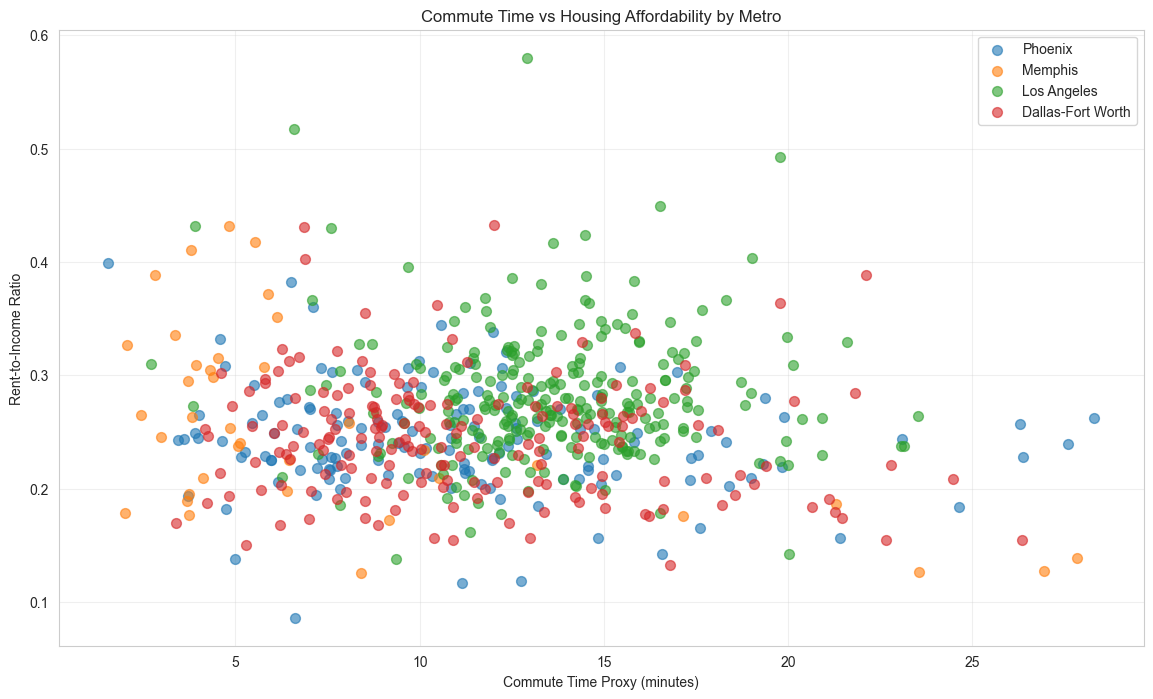

In [8]:
# Scatter plot: commute time vs rent-to-income
plt.figure(figsize=(14, 8))
for metro in df['metro'].unique():
    metro_data = df[df['metro'] == metro]
    plt.scatter(metro_data['commute_min_proxy'], metro_data['rent_to_income'], 
                label=metro, alpha=0.6, s=50)

plt.xlabel('Commute Time Proxy (minutes)')
plt.ylabel('Rent-to-Income Ratio')
plt.title('Commute Time vs Housing Affordability by Metro')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1200x600 with 0 Axes>

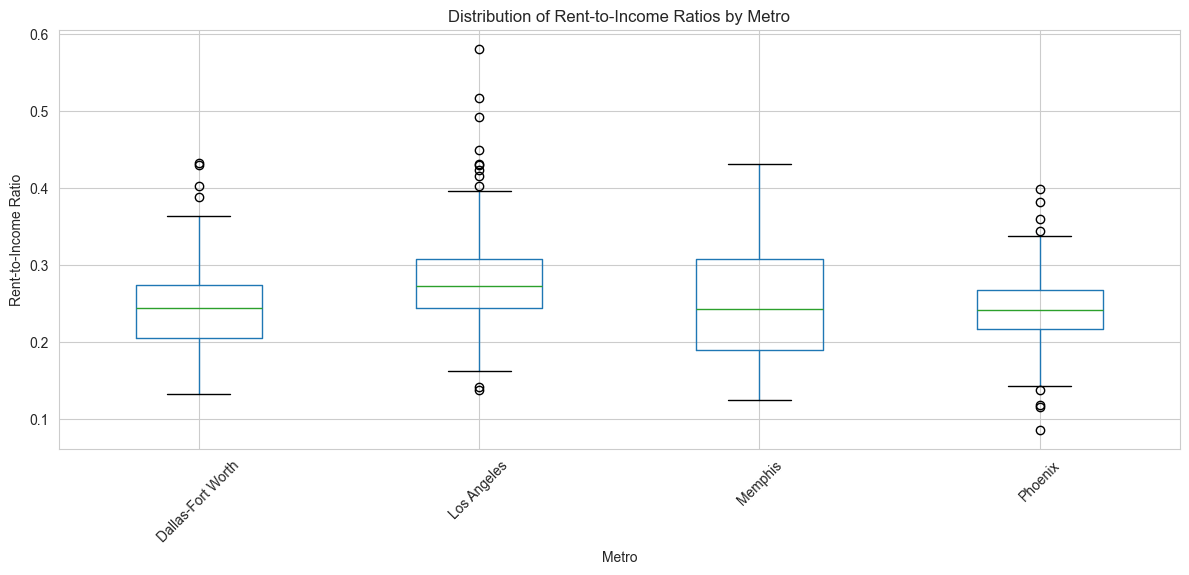

In [9]:
# Distribution of rent-to-income by metro
plt.figure(figsize=(12, 6))
df.boxplot(column='rent_to_income', by='metro', figsize=(12, 6))
plt.suptitle('')
plt.title('Distribution of Rent-to-Income Ratios by Metro')
plt.xlabel('Metro')
plt.ylabel('Rent-to-Income Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Transit Access Analysis

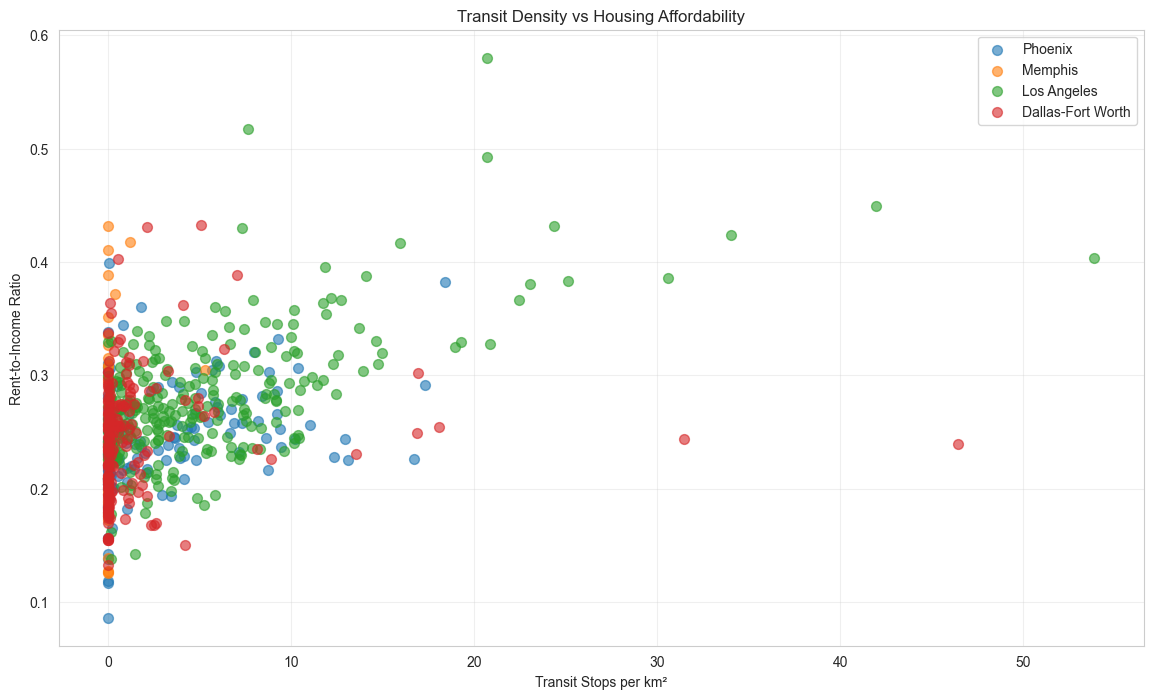

In [10]:
# Transit density vs affordability
plt.figure(figsize=(14, 8))
for metro in df['metro'].unique():
    metro_data = df[df['metro'] == metro]
    plt.scatter(metro_data['stops_per_km2'], metro_data['rent_to_income'], 
                label=metro, alpha=0.6, s=50)

plt.xlabel('Transit Stops per km²')
plt.ylabel('Rent-to-Income Ratio')
plt.title('Transit Density vs Housing Affordability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Key Relationship Visualizations

To understand the core relationships between housing affordability, commute patterns, and transit access, we examine scatter plots of the primary variables. Plotting commute time vs rent-to-income ratio and transit density vs rent-to-income ratio provides insight into the tradeoffs residents face across these metros.

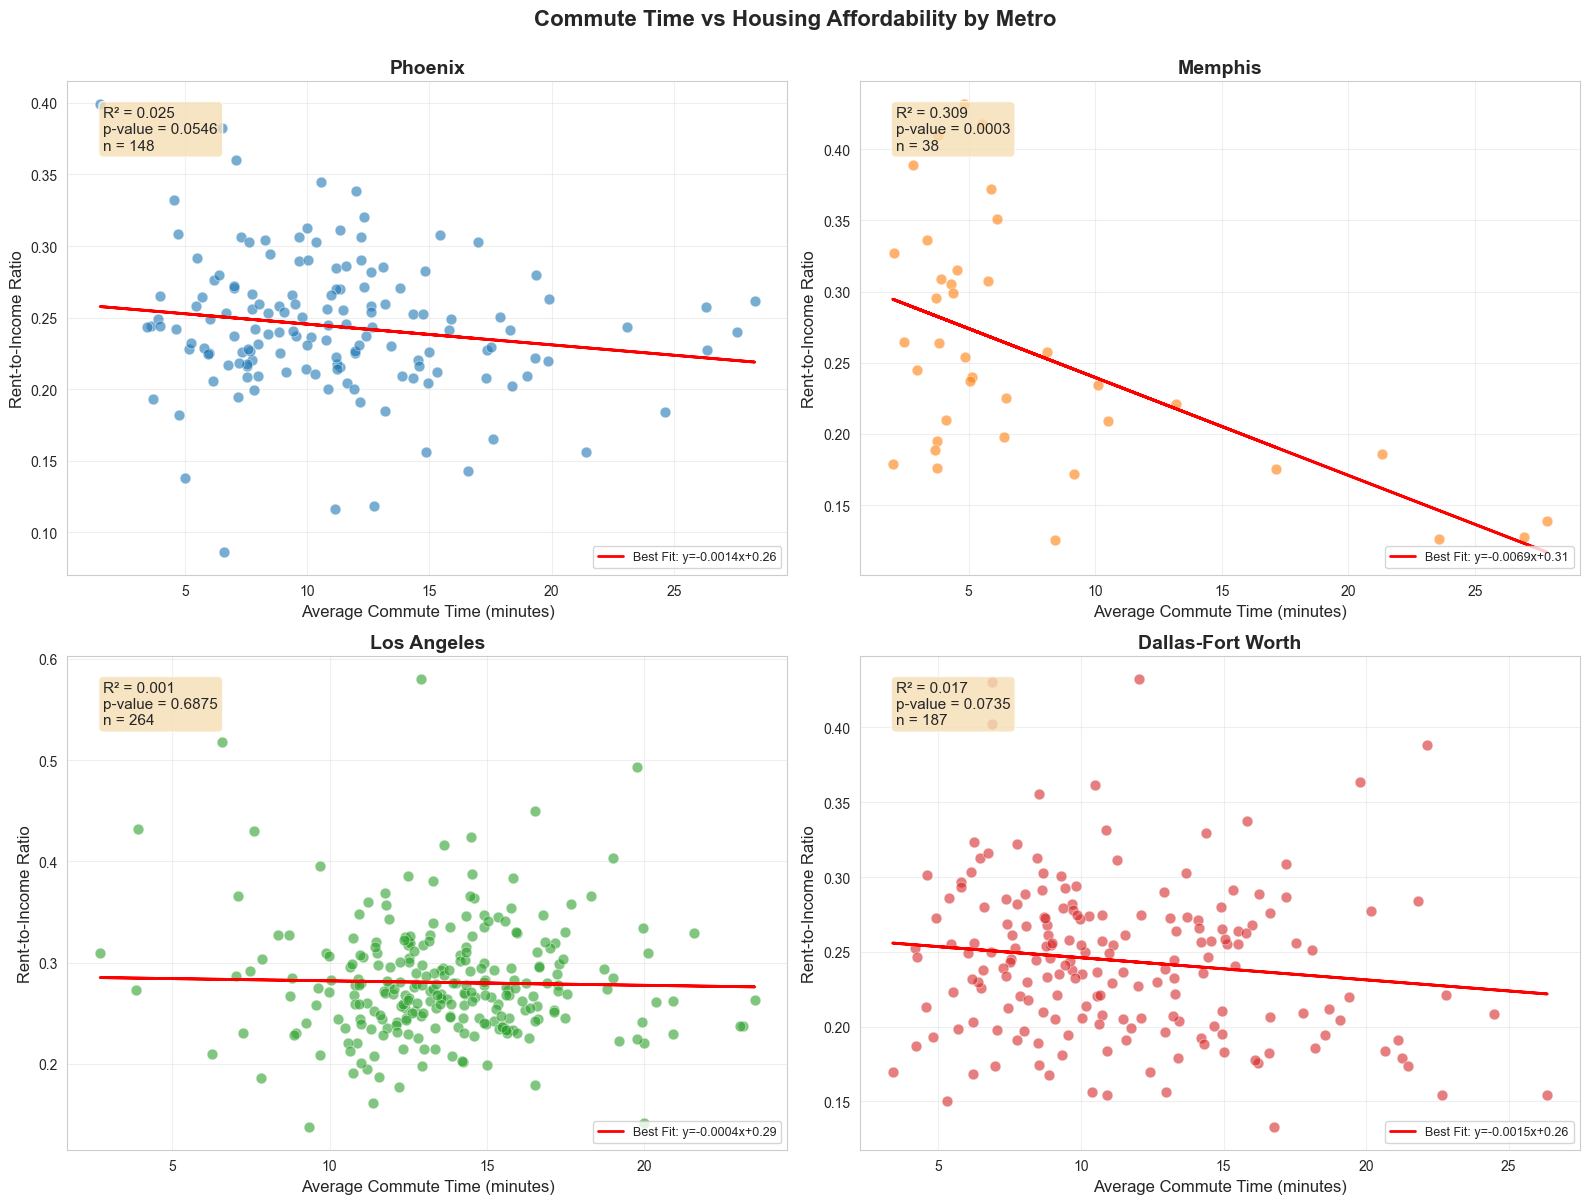

In [11]:
# Import scipy for regression
from scipy import stats

# Create 2x2 grid of subplots for each metro
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metros = ['Phoenix', 'Memphis', 'Los Angeles', 'Dallas-Fort Worth']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (metro_name, color, ax) in enumerate(zip(metros, colors, axes)):
    # Filter data for this metro
    metro_data = df[df['metro'] == metro_name].dropna(subset=['commute_min_proxy', 'rent_to_income'])
    
    x = metro_data['commute_min_proxy']
    y = metro_data['rent_to_income']
    
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.6, s=60, color=color, edgecolors='white', linewidth=0.5)
    
    # Best fit line
    ax.plot(x, line, color='red', linewidth=2, label=f'Best Fit: y={slope:.4f}x+{intercept:.2f}')
    
    # Add statistics to plot
    ax.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np-value = {p_value:.4f}\nn = {len(x)}',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel('Average Commute Time (minutes)', fontsize=12)
    ax.set_ylabel('Rent-to-Income Ratio', fontsize=12)
    ax.set_title(f'{metro_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Commute Time vs Housing Affordability by Metro', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

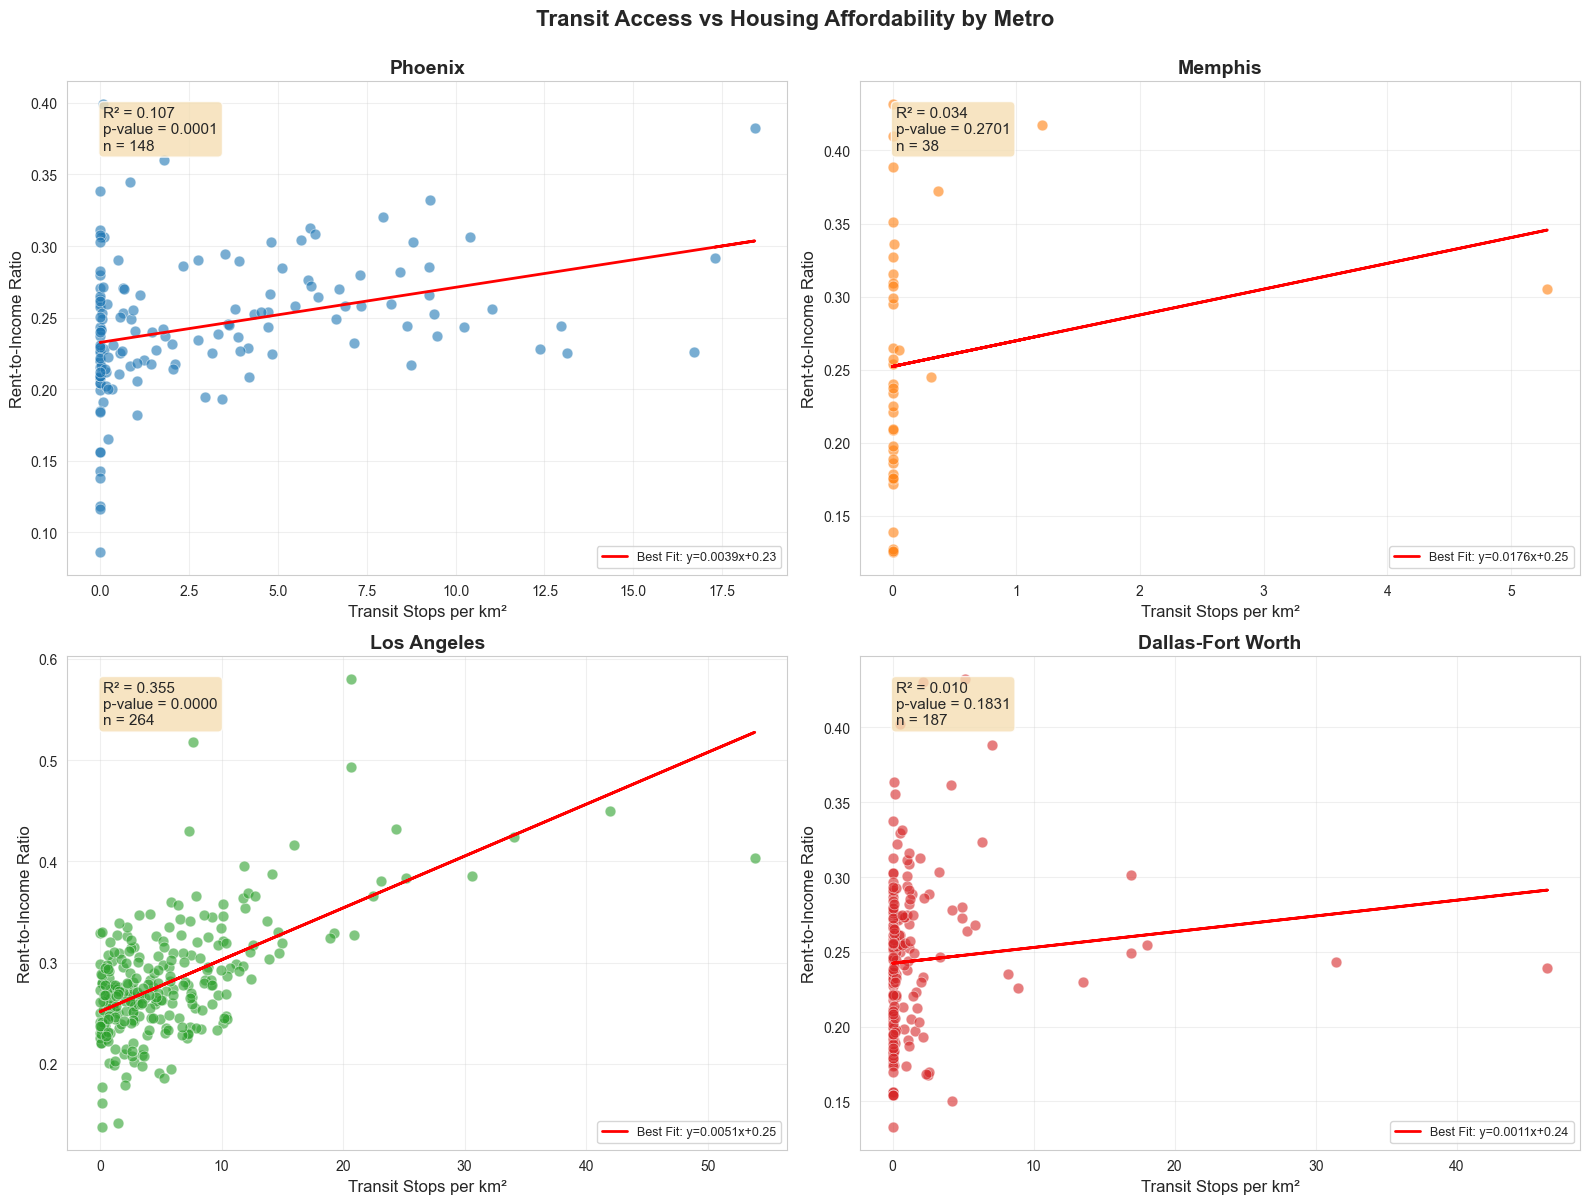

In [12]:
# Create 2x2 grid for Transit Density vs Affordability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (metro_name, color, ax) in enumerate(zip(metros, colors, axes)):
    # Filter data for this metro
    metro_data = df[df['metro'] == metro_name].dropna(subset=['stops_per_km2', 'rent_to_income'])
    
    x = metro_data['stops_per_km2']
    y = metro_data['rent_to_income']
    
    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.6, s=60, color=color, edgecolors='white', linewidth=0.5)
    
    # Best fit line
    ax.plot(x, line, color='red', linewidth=2, label=f'Best Fit: y={slope:.4f}x+{intercept:.2f}')
    
    # Add statistics to plot
    ax.text(0.05, 0.95, f'R² = {r_value**2:.3f}\np-value = {p_value:.4f}\nn = {len(x)}',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel('Transit Stops per km²', fontsize=12)
    ax.set_ylabel('Rent-to-Income Ratio', fontsize=12)
    ax.set_title(f'{metro_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Transit Access vs Housing Affordability by Metro', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Interpretation

To understand the relationships between housing affordability, commute patterns, and transit access, I created scatter plots with linear regression lines for each metropolitan area. The visualizations plot commute time versus rent-to-income ratio and transit density versus rent-to-income ratio across the four metros, displaying R² values and statistical significance measures for each relationship.

The commute time analysis reveals distinct patterns across metros. Memphis shows the strongest relationship (R² = 0.309, p = 0.0003), with commute time explaining approximately 31% of the variation in rent burden. The negative slope indicates that for every additional minute of commute time, rent-to-income ratios decrease by approximately 0.002 units, suggesting a meaningful affordability tradeoff where residents accept longer commutes in exchange for lower housing costs. This pattern aligns with the classic "drive til you qualify" phenomenon documented in sprawling metropolitan areas.

Phoenix and Dallas-Fort Worth show much weaker relationships (R² = 0.025 and 0.017 respectively), with commute time explaining less than 3% of rent burden variation. While both metros exhibit slight negative trends, neither reaches statistical significance (p > 0.05). This suggests that in these Sun Belt metros, factors beyond commute distance (such as zoning regulations, income inequality, and localized demand pressures) exert stronger influence on housing affordability. The wide scatter of data points indicates substantial variation in rent burdens even among ZCTAs with similar commute times.

Los Angeles presents the most compressed pattern (R² = 0.001, p = 0.6875), with essentially no relationship between commute time and affordability. The flat regression line confirms that longer commutes provide no affordability advantage in this high-cost market. Even peripheral ZCTAs face significant rent burdens. The high baseline rent-to-income ratios across all commute times reflect the region's constrained housing supply and intense demand pressures.

The transit density plots reveal a different dynamic. Higher transit accessibility correlates with elevated rent burdens in Los Angeles, where transit-rich areas command premium rents due to location desirability and reduced transportation costs. Phoenix and Dallas-Fort Worth show large clusters of ZCTAs with minimal transit infrastructure (near 0 stops/km²), reflecting the automobile-dependent character of these sprawling metros. Memphis falls between these extremes, with moderate transit coverage and moderate rent burdens. ZCTAs appearing in the upper-left quadrant of each transit plot (characterized by high rent burdens despite limited transit access) face particularly acute combined pressure, as residents must shoulder both elevated housing costs and limited public transportation alternatives.

## Advanced Visualizations

### Quadrant Analysis: Identifying Pressure Zones

This visualization divides ZCTAs into four categories based on median commute time and rent burden, helping identify areas facing combined affordability and commute pressures.

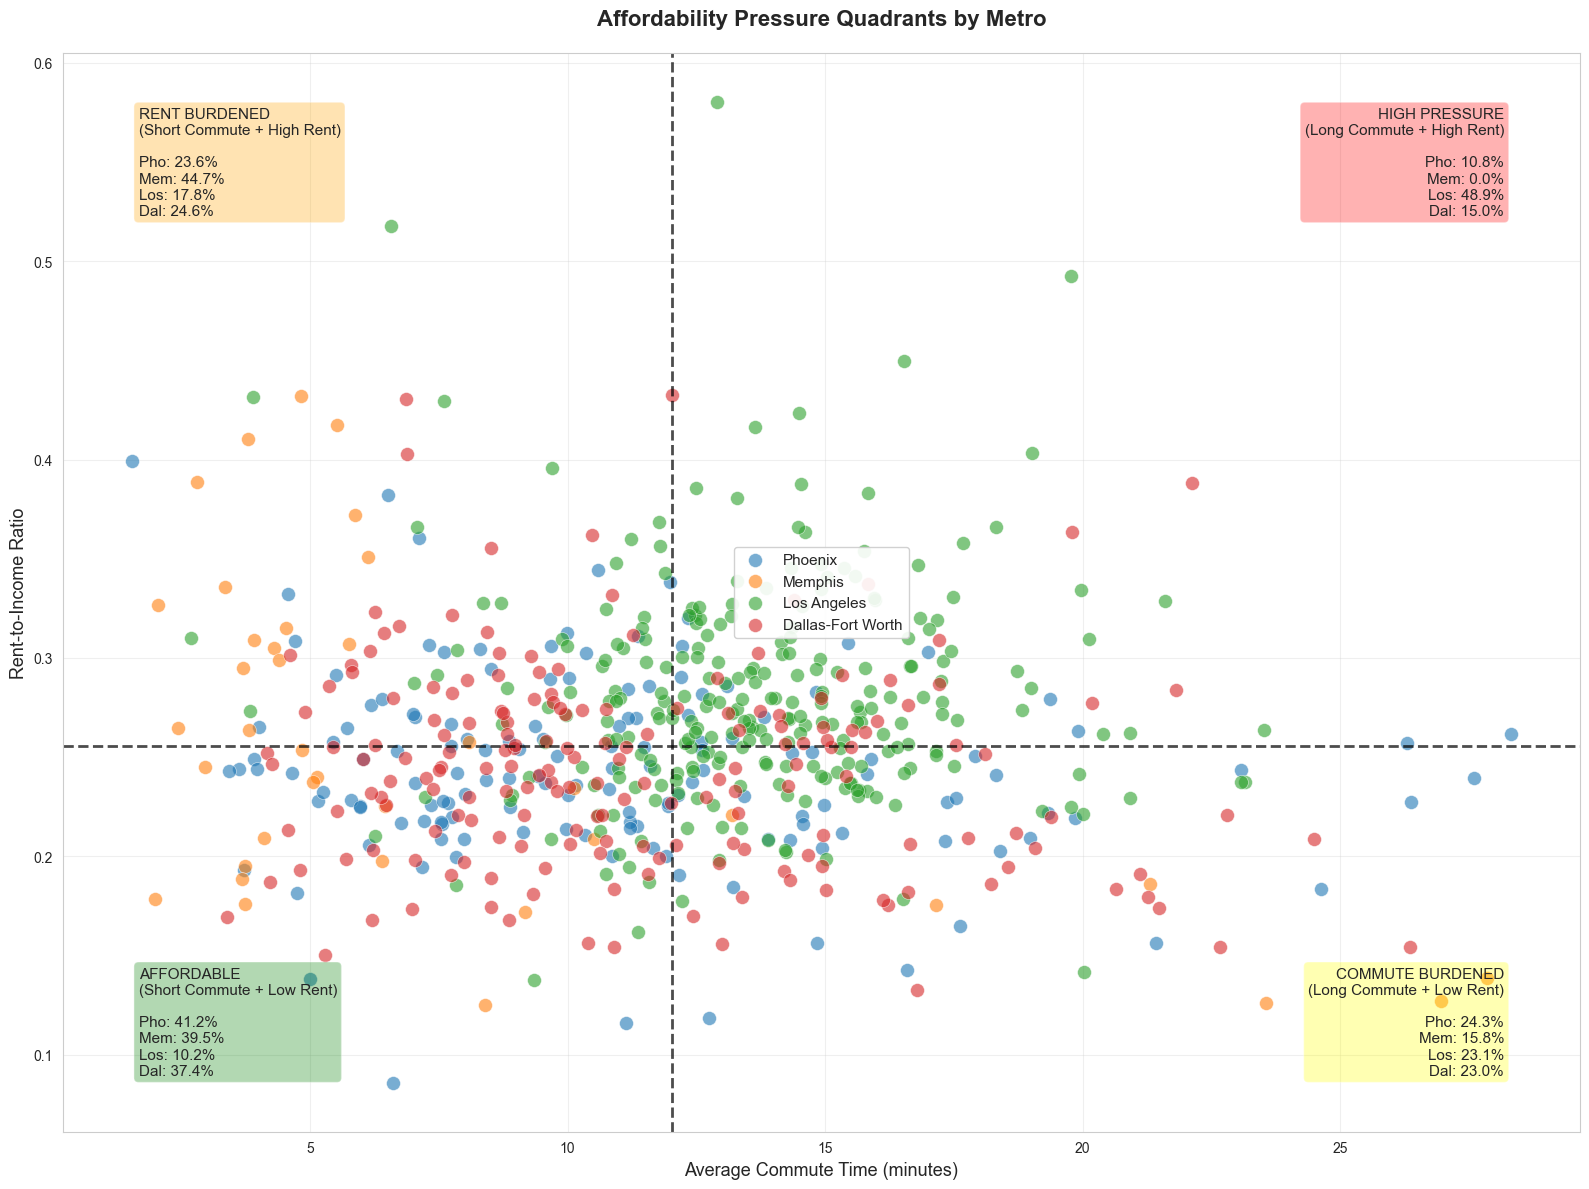


ZCTA Distribution by Quadrant:

Phoenix:
  High Pressure: 16 (10.8%)
  Rent Burdened: 35 (23.6%)
  Commute Burdened: 36 (24.3%)
  Affordable: 61 (41.2%)

Memphis:
  High Pressure: 0 (0.0%)
  Rent Burdened: 17 (44.7%)
  Commute Burdened: 6 (15.8%)
  Affordable: 15 (39.5%)

Los Angeles:
  High Pressure: 129 (48.9%)
  Rent Burdened: 47 (17.8%)
  Commute Burdened: 61 (23.1%)
  Affordable: 27 (10.2%)

Dallas-Fort Worth:
  High Pressure: 28 (15.0%)
  Rent Burdened: 46 (24.6%)
  Commute Burdened: 43 (23.0%)
  Affordable: 70 (37.4%)


In [15]:
# Quadrant Analysis: Affordability Pressure Zones
fig, ax = plt.subplots(figsize=(16, 12))

# Calculate medians for quadrant lines
commute_median = df['commute_min_proxy'].median()
rent_median = df['rent_to_income'].median()

# Plot each metro with distinct colors
colors = {'Phoenix': '#1f77b4', 'Memphis': '#ff7f0e', 
          'Los Angeles': '#2ca02c', 'Dallas-Fort Worth': '#d62728'}

for metro in df['metro'].unique():
    metro_data = df[df['metro'] == metro].dropna(subset=['commute_min_proxy', 'rent_to_income'])
    ax.scatter(metro_data['commute_min_proxy'], metro_data['rent_to_income'], 
               label=metro, alpha=0.6, s=100, edgecolors='white', linewidth=0.5,
               color=colors[metro])

# Add quadrant lines
ax.axvline(commute_median, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax.axhline(rent_median, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Calculate quadrant statistics for annotations
quadrant_text = {'high_pressure': [], 'rent_burdened': [], 'commute_burdened': [], 'affordable': []}

for metro in ['Phoenix', 'Memphis', 'Los Angeles', 'Dallas-Fort Worth']:
    metro_data = df[df['metro'] == metro].dropna(subset=['commute_min_proxy', 'rent_to_income'])
    total = len(metro_data)
    
    high_pressure = len(metro_data[(metro_data['commute_min_proxy'] > commute_median) & 
                                    (metro_data['rent_to_income'] > rent_median)])
    rent_burdened = len(metro_data[(metro_data['commute_min_proxy'] <= commute_median) & 
                                    (metro_data['rent_to_income'] > rent_median)])
    commute_burdened = len(metro_data[(metro_data['commute_min_proxy'] > commute_median) & 
                                       (metro_data['rent_to_income'] <= rent_median)])
    affordable = len(metro_data[(metro_data['commute_min_proxy'] <= commute_median) & 
                                 (metro_data['rent_to_income'] <= rent_median)])
    
    quadrant_text['high_pressure'].append(f"{metro[:3]}: {high_pressure/total*100:.1f}%")
    quadrant_text['rent_burdened'].append(f"{metro[:3]}: {rent_burdened/total*100:.1f}%")
    quadrant_text['commute_burdened'].append(f"{metro[:3]}: {commute_burdened/total*100:.1f}%")
    quadrant_text['affordable'].append(f"{metro[:3]}: {affordable/total*100:.1f}%")

# Label quadrants with statistics
ax.text(0.95, 0.95, 'HIGH PRESSURE\n(Long Commute + High Rent)\n\n' + '\n'.join(quadrant_text['high_pressure']), 
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
ax.text(0.05, 0.95, 'RENT BURDENED\n(Short Commute + High Rent)\n\n' + '\n'.join(quadrant_text['rent_burdened']), 
        transform=ax.transAxes, ha='left', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
ax.text(0.95, 0.05, 'COMMUTE BURDENED\n(Long Commute + Low Rent)\n\n' + '\n'.join(quadrant_text['commute_burdened']), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax.text(0.05, 0.05, 'AFFORDABLE\n(Short Commute + Low Rent)\n\n' + '\n'.join(quadrant_text['affordable']), 
        transform=ax.transAxes, ha='left', va='bottom', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

ax.set_xlabel('Average Commute Time (minutes)', fontsize=13)
ax.set_ylabel('Rent-to-Income Ratio', fontsize=13)
ax.set_title('Affordability Pressure Quadrants by Metro', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='center', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed breakdown
print('\nZCTA Distribution by Quadrant:')
print('='*60)
for metro in df['metro'].unique():
    metro_data = df[df['metro'] == metro].dropna(subset=['commute_min_proxy', 'rent_to_income'])
    high_pressure = len(metro_data[(metro_data['commute_min_proxy'] > commute_median) & 
                                    (metro_data['rent_to_income'] > rent_median)])
    rent_burdened = len(metro_data[(metro_data['commute_min_proxy'] <= commute_median) & 
                                    (metro_data['rent_to_income'] > rent_median)])
    commute_burdened = len(metro_data[(metro_data['commute_min_proxy'] > commute_median) & 
                                       (metro_data['rent_to_income'] <= rent_median)])
    affordable = len(metro_data[(metro_data['commute_min_proxy'] <= commute_median) & 
                                 (metro_data['rent_to_income'] <= rent_median)])
    total = len(metro_data)
    
    print(f'\n{metro}:')
    print(f'  High Pressure: {high_pressure} ({high_pressure/total*100:.1f}%)')
    print(f'  Rent Burdened: {rent_burdened} ({rent_burdened/total*100:.1f}%)')
    print(f'  Commute Burdened: {commute_burdened} ({commute_burdened/total*100:.1f}%)')
    print(f'  Affordable: {affordable} ({affordable/total*100:.1f}%)')

### Metro Profile Comparison

Radar charts comparing metros across five dimensions: rent burden, average commute time, share of long commutes, transit density, and median rent levels.

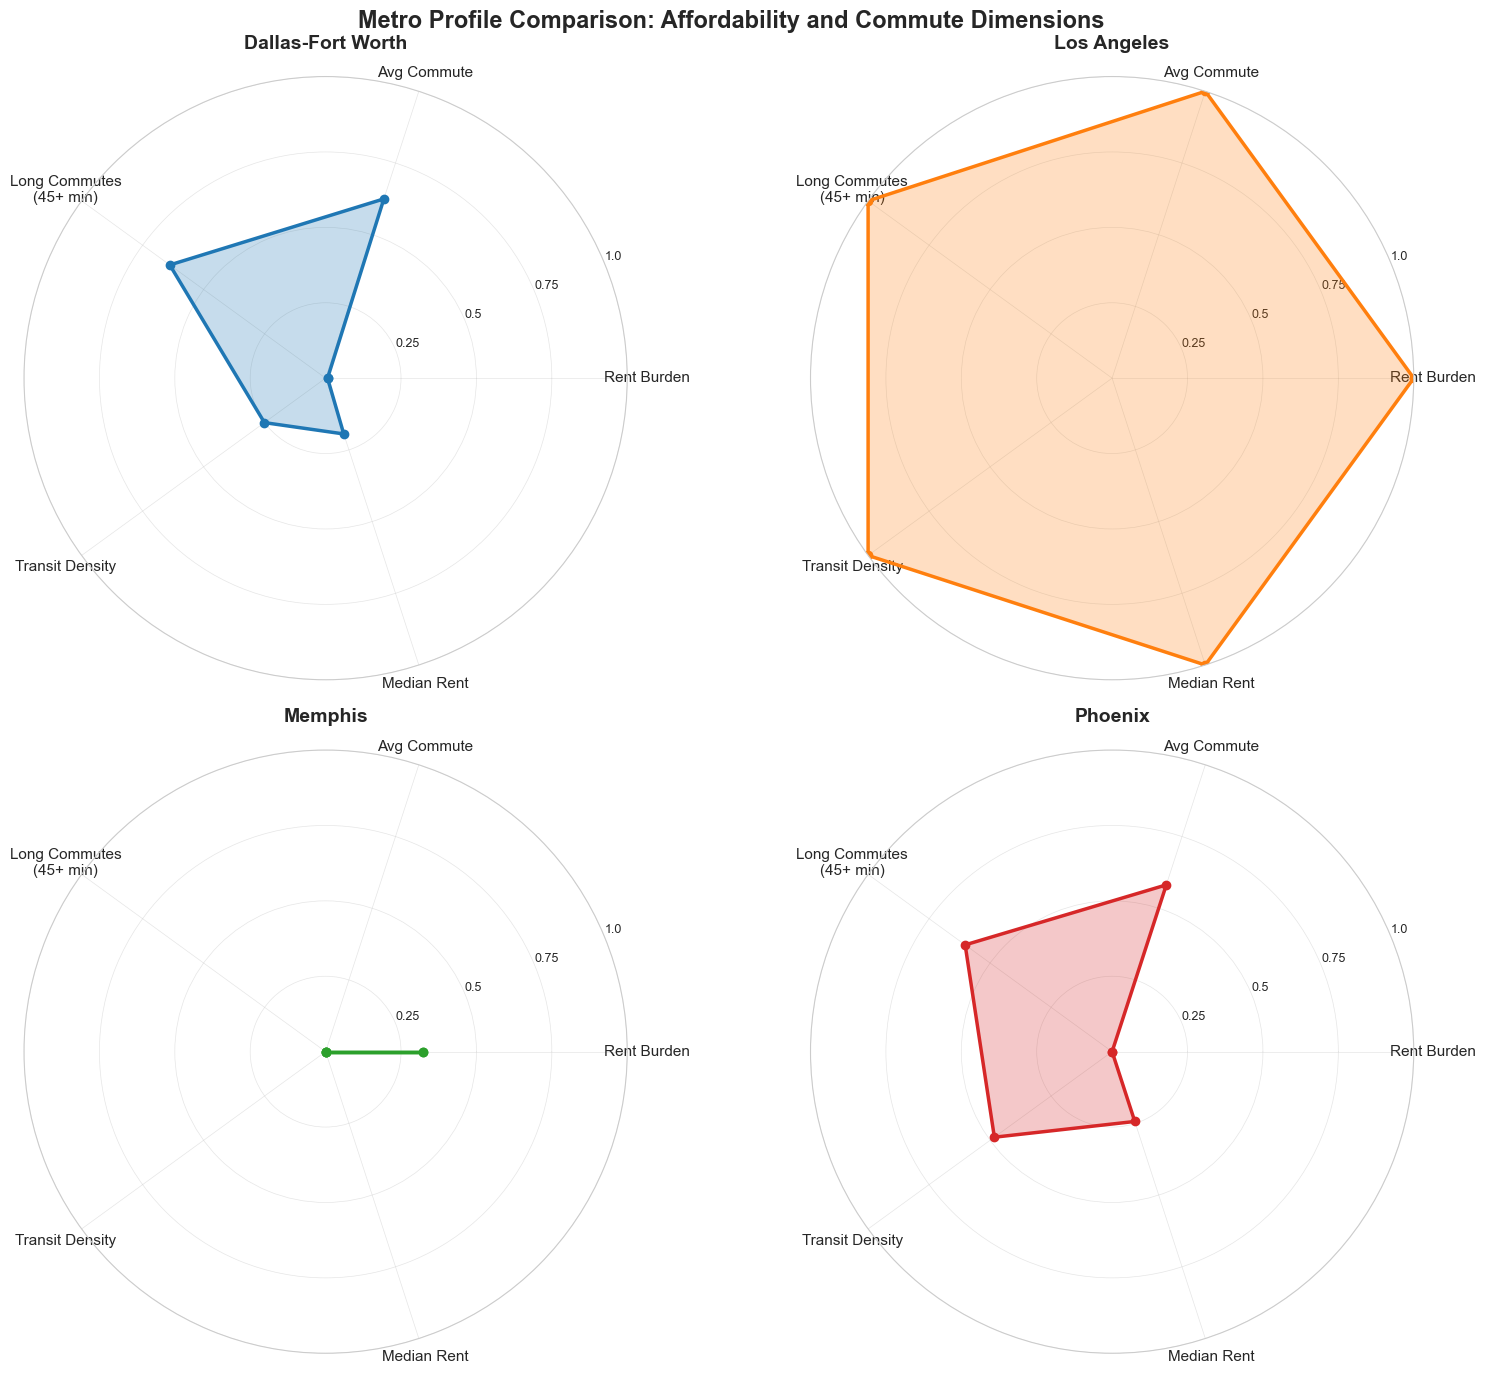


Metro Statistics (Actual Values):
Metro                Rent Burden     Avg Commute     Long Commute %    Transit/km²     ZORI ($)  
----------------------------------------------------------------------------------------------------
Dallas-Fort Worth    0.244           11.35           15.86             1.58            $1776      
Los Angeles          0.280           13.56           18.63             5.73            $3082      
Memphis              0.256           7.68            10.98             0.19            $1460      
Phoenix              0.244           11.10           15.58             2.86            $1855      


In [16]:
# Metro Comparison Radar Chart
from math import pi

# Calculate metro averages
metro_stats = df.groupby('metro').agg({
    'rent_to_income': 'mean',
    'commute_min_proxy': 'mean',
    'long45_share': 'mean',
    'stops_per_km2': 'mean',
    'zori': 'mean'
}).reset_index()

# Normalize to 0-1 scale for radar chart
for col in ['rent_to_income', 'commute_min_proxy', 'long45_share', 'stops_per_km2', 'zori']:
    metro_stats[f'{col}_norm'] = (metro_stats[col] - metro_stats[col].min()) / \
                                  (metro_stats[col].max() - metro_stats[col].min())

# Set up radar chart
categories = ['Rent Burden', 'Avg Commute', 'Long Commutes\n(45+ min)', 
              'Transit Density', 'Median Rent']
N = len(categories)

fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (ax, color) in enumerate(zip(axes, colors_list)):
    metro = metro_stats.iloc[idx]['metro']
    values = metro_stats.iloc[idx][[
        'rent_to_income_norm', 'commute_min_proxy_norm', 
        'long45_share_norm', 'stops_per_km2_norm', 'zori_norm'
    ]].values.tolist()
    values += values[:1]  # Complete the circle
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2.5, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=11)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], size=9)
    ax.set_title(metro, size=14, fontweight='bold', pad=20)
    ax.grid(True, linewidth=0.5, alpha=0.5)

plt.suptitle('Metro Profile Comparison: Affordability and Commute Dimensions', 
             fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print actual values table
print('\nMetro Statistics (Actual Values):')
print('='*100)
print(f"{'Metro':<20} {'Rent Burden':<15} {'Avg Commute':<15} {'Long Commute %':<17} {'Transit/km²':<15} {'ZORI ($)':<10}")
print('-'*100)
for idx, row in metro_stats.iterrows():
    print(f"{row['metro']:<20} {row['rent_to_income']:<15.3f} {row['commute_min_proxy']:<15.2f} "
          f"{row['long45_share']*100:<17.2f} {row['stops_per_km2']:<15.2f} ${row['zori']:<10.0f}")

## Next Steps

**Data gaps to address:**
- Add demographic data (Census B03002, B02001, B19013) for RQ2
- Restructure for time-series panel data for RQ3
- Verify metro configurations (county FIPS codes)

**Analysis priorities:**
1. Continue EDA on RQ1 with current data
2. Add demographic variables for equity analysis
3. Pull historical data for longitudinal analysis